In [1]:
import pandas as pd #csv file 불러오기
import numpy as np #행렬연산
import matplotlib.pyplot as plt #시각화
from keras.models import Sequential #keras 딥러닝모델
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime

In [3]:
data = pd.read_csv(r'D:/shinj/Data/[1]pred-bitcoin/Data/bitcoin.csv') #csv데이터셋 로드
data.head() #상위 5라인 출력


,Date,Open,High,Low,Close,Volume,Market Cap
0,29-Apr-13,134,147,134,145,0,1603768865
1,30-Apr-13,144,147,134,139,0,1542813125
2,01-May-13,139,140,108,117,0,1298954594
3,02-May-13,116,126,92,105,0,1168517495
4,03-May-13,106,108,79,98,0,1085995169


In [4]:
high_prices = data['High'].values #최고값 저장
low_prices = data['Low'].values #최저값 저장
mid_prices = (high_prices + low_prices) / 2 #csv데이터에 , 가 있으면 연산불가, 중간가격 연산

In [5]:
#윈도우생성
seq_len = 50 #윈도우사이즈 50(50일의 데이터를 확인후 다음날짜 예측)
sequence_length = seq_len + 1 #50일+1(다음날짜)

result = [] #result변수에 51개씩 저장
for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index: index + sequence_length])

In [6]:
#데이터 정규화
def normalize_windows(data):
    normalized_data = []
    
    for window in data:
        normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
        #첫번째 윈도우값0 기준,(현재날짜/이전날짜)-1
        normalized_data.append(normalized_window)
    return np.array(normalized_data)

result = normalize_windows(result) #정규화 결과값 저장

#트레이닝 데이터셋0.9 / 테스트 데이터셋 0.1
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train) # 트레이닝데이터셋 랜덤셔플(예측의 적응대비)

x_train = train[:, :-1]#0.9 트레이닝데이터
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]#0.1 테스트데이터

x_test = result[row:, :-1]#0.9 트레이닝데이터
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]#0.1 테스트데이터

x_train.shape, x_test.shape
#2361일의 데이터로 262일의 값예측

((2361, 50, 1), (262, 50, 1))

In [7]:
model = Sequential()#모델을 순차적으로 정의

model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))

model.add(LSTM(64, return_sequences=False))#조정하면서 성능파악

model.add(Dense(1, activation='linear'))#다음날 1일 예측

model.compile(loss='mse', optimizer='rmsprop')

model.summary()#개요출력

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


In [8]:
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
#트레이닝
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10, #한번에 학습시킬 묶음
    epochs=20, #20번동안 반복학습
    callbacks=[
        TensorBoard(log_dir='logs/%s' % (start_time)),
        ModelCheckpoint('./models/%s_eth.h5' % (start_time), monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='auto')
])

Epoch 1/20
  1/237 [..............................] - ETA: 0s - loss: 0.1044WARNING:tensorflow:From C:\Users\shinj\anaconda3\envs\ML\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
237/237 [==============================] - ETA: 0s - loss: 0.0629
Epoch 00001: val_loss improved from inf to 0.00429, saving model to ./models\2020_09_28_00_21_09_eth.h5
237/237 [==============================] - 16s 67ms/step - loss: 0.0629 - val_loss: 0.0043
Epoch 2/20
236/237 [============================>.] - ETA: 0s - loss: 0.0300
Epoch 00002: val_loss did not improve from 0.00429
237/237 [==============================] - 11s 46ms/step - loss: 0.0300 - val_loss: 0.0054
Epoch 3/20
237/237 [==============================] - ETA: 0s - loss: 0.0215
Epoch 00003: val_loss did not improve from 0.00429
237/237 [=================

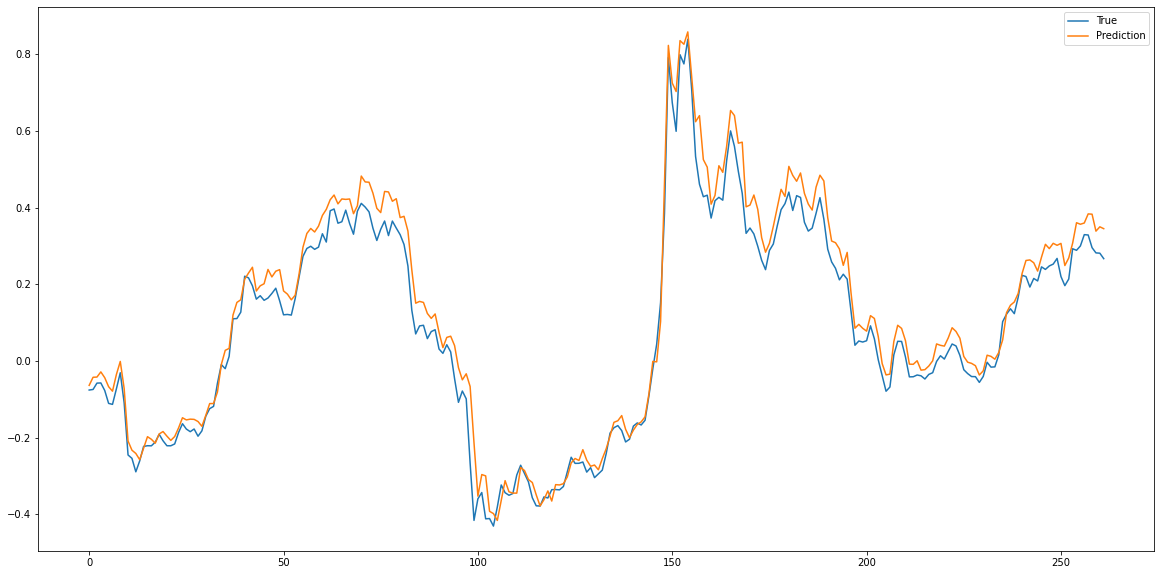

In [9]:
#검증및 가시화
pred = model.predict(x_test)#모델을 사용해 예측

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()